# CNN Model 2a
## Preprocessing method: ImageDataGenerator()
## Image size: (224, 224) 
## Images: RGB
## No pretrained layers
## Image transformation

In [1]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
from keras import backend as K
K.clear_session()

In [3]:
path_training = 'gender_images/Training/'
path_validation = 'gender_images/Validation/'

In [4]:
image_size = (224, 224)
batch_size = 128
datagen_transform = ImageDataGenerator(
    rescale =1./255,
    validation_split=.2,
    rotation_range=20,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(
    rescale = 1./255,
)

train_ds = datagen_transform.flow_from_directory(
    path_training,
    seed=1993,
    target_size=image_size,
    batch_size=batch_size,
    classes=['female','male'],
    shuffle=True,
    color_mode="rgb"
)

val_ds = datagen_transform.flow_from_directory(
    path_validation,
    seed=1993,
    target_size=image_size,
    batch_size=batch_size,
    classes=['female','male'],
    shuffle=True,
    color_mode="rgb"
)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [5]:
inputs = keras.Input(shape=image_size)
x = layers.Rescaling(1./255)(inputs)

In [6]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 2
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [7]:
# Set early stopping after certain number of epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs = 1000     # Set epochs

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                              

                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 28, 28, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 28, 28, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 512)  131584      ['add_1[0][0]']                  
          

In [9]:
face_fit = model.fit(
  train_ds,
  validation_data= val_ds,
  epochs=epochs,
  callbacks=[callback],
    workers=12
)

Epoch 1/1000
368/368 [==============================] - 145s 373ms/step - loss: 0.3588 - accuracy: 0.8389 - val_loss: 0.7954 - val_accuracy: 0.4986
Epoch 2/1000
368/368 [==============================] - 139s 372ms/step - loss: 0.1944 - accuracy: 0.9261 - val_loss: 0.6690 - val_accuracy: 0.5854
Epoch 3/1000
368/368 [==============================] - 138s 370ms/step - loss: 0.1605 - accuracy: 0.9411 - val_loss: 1.1534 - val_accuracy: 0.5012
Epoch 4/1000
368/368 [==============================] - 138s 369ms/step - loss: 0.1517 - accuracy: 0.9452 - val_loss: 3.6297 - val_accuracy: 0.5014
Epoch 5/1000
368/368 [==============================] - 139s 370ms/step - loss: 0.1447 - accuracy: 0.9471 - val_loss: 0.7799 - val_accuracy: 0.4989
Epoch 6/1000
368/368 [==============================] - 138s 369ms/step - loss: 0.1380 - accuracy: 0.9499 - val_loss: 1.2137 - val_accuracy: 0.5014
Epoch 7/1000
368/368 [==============================] - 140s 373ms/step - loss: 0.1314 - accuracy: 0.9533 - val_

368/368 [==============================] - 137s 368ms/step - loss: 0.0758 - accuracy: 0.9728 - val_loss: 0.6118 - val_accuracy: 0.6698
Epoch 57/1000
368/368 [==============================] - 137s 367ms/step - loss: 0.0778 - accuracy: 0.9717 - val_loss: 0.6965 - val_accuracy: 0.5455
Epoch 58/1000
368/368 [==============================] - 137s 367ms/step - loss: 0.0760 - accuracy: 0.9728 - val_loss: 0.7930 - val_accuracy: 0.5033
Epoch 59/1000
368/368 [==============================] - 138s 368ms/step - loss: 0.0741 - accuracy: 0.9728 - val_loss: 4.9363 - val_accuracy: 0.5014
Epoch 60/1000
368/368 [==============================] - 137s 368ms/step - loss: 0.0748 - accuracy: 0.9729 - val_loss: 1.1877 - val_accuracy: 0.5014
Epoch 61/1000
368/368 [==============================] - 138s 368ms/step - loss: 0.0736 - accuracy: 0.9733 - val_loss: 0.9715 - val_accuracy: 0.4994
Epoch 62/1000
368/368 [==============================] - 137s 368ms/step - loss: 0.0731 - accuracy: 0.9732 - val_loss: 8

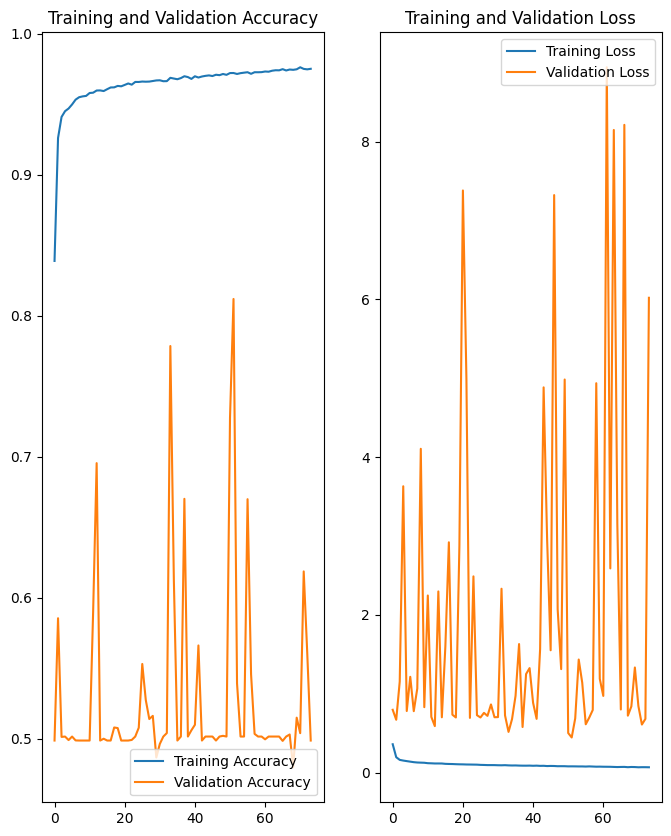

In [10]:
acc= face_fit.history['accuracy']
val_acc = face_fit.history['val_accuracy']

loss = face_fit.history['loss']
val_loss = face_fit.history['val_loss']

import matplotlib.pyplot as plt

epochs_range = range(0,74)

plt.figure(figsize=(8, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [11]:
print(str('Top Training Accuracy: ') + str(round(max(acc),4)))
print(str('Top Validation Accuracy: ') + str(round(max(val_acc),4)))

Top Training Accuracy: 0.9763
Top Validation Accuracy: 0.8119


In [12]:
model.save('GC weights/Unfrozen/mod2a-RGB/mod2a_RGB.h5')